In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from utils import EnhancerDataset, split_dataset, train_model, regression_model_plot,EnhancerDatasetWithID
import pandas as pd
from tqdm import tqdm
import glob
import torch.nn as nn
import torch.nn.modules.activation as activation
import sys
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import interpretation
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../model')  
from model import ConvNetDeep, DanQ, ExplaiNN,ConvNetDeep2, ExplaiNN2, ExplaiNN3,DeepSTARR


In [2]:
def evaluate_model_with_weights(model, data_loader, weight_file, device):
    model.load_state_dict(torch.load(weight_file, map_location=device))
    model.eval()
    
    all_predictions, all_labels, all_fragment_ids = [], [], []
    with torch.no_grad():
        for inputs, labels, fragment_ids in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_fragment_ids.append(fragment_ids)
    
    return (np.concatenate(all_predictions),
            np.concatenate(all_labels),
            np.concatenate(all_fragment_ids))

def process_and_save_results(data_loader, loader_name, model, weight_file, target_labels, output_dir, device, save = True):
    predictions, labels, fragment_ids = evaluate_model_with_weights(model, data_loader, weight_file, device)
    
    # Construct DataFrame
    data = {'Fragment_ID': fragment_ids}
    for i, label in enumerate(target_labels):
        data[f'Predictions_{label}'] = predictions[:, i]
        data[f'True_{label}'] = labels[:, i]

    # Create and save DataFrame
    df_predictions = pd.DataFrame(data)
    if save:
        output_file = f'{output_dir}/{loader_name}_prediction_results.csv'
        df_predictions.to_csv(output_file, index=False)
        print(f"Results for {loader_name} saved to {output_file}")
    return df_predictions


# Train ExplaiNN Predict Merged G+ and G-

In [8]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_G+G-_Metrics.csv')
cnns = list(set(params['num_cnns']))

temp_df = params[params['num_cnns'] == 75]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

num_cnns = 75
target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred_75NN'

print(f'cnn: {num_cnns}')
print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

seed = best_seed
batch = best_batch
learning_rate= best_lr

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_merged_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)

# Process datasets
train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode = 'none')
test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode = 'none')
validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)


input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 2, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader,test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

cnn: 75
lr: 0.0001    drop_out: 0.3
batch: 168    seed: 350
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/60, Loss: 80.1401
Epoch 1/200 -- Train Loss: 78.0166 , Validation Loss: 75.5607
------------------------Evaluation------------------------
Label 1: MSE=78.3085, RMSE=8.8492, MAE=8.8441, R^2=-1333.2253, Pearson=0.1564, Spearman=0.1405
Label 2: MSE=72.8183, RMSE=8.5334, MAE=8.5287, R^2=-1977.2537, Pearson=0.0184, Spearman=0.0248
Overall (Flattened): MSE=75.5634, RMSE=8.6927, MAE=8.6864, R^2=-1518.8246, Pearson=-0.0100, Spearman=-0.0082
----------------------------------------------------------
Epoch 2/200, Step 1/60, Loss: 76.1146
Epoch 2/200 -- Train Loss: 73.7227 , Validation Loss: 71.9948
------------------------Evaluation------------------------
Label 1: MSE=74.7816, RMSE=8.6476, MAE=8.6426, R^2=-1273.1338, Pearson=0.2195, Spearman=0.2094
Label 2: MSE=69.2115, RMSE=8.3193, MAE=8.3148, R^2=-1879.2680, Pearson=0.0807, Spearman=0.0878
Overall (Flattened): MSE=71.

In [9]:
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred_75NN/best_pearson*.pth')
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred_75NN'

for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    _ = process_and_save_results(train_loader, 'train', input_model, weight_file, target_labels, output_dir, device)
    _  = process_and_save_results(val_loader, 'validation', input_model, weight_file, target_labels, output_dir, device)
    df_predictions = process_and_save_results(test_loader, 'test', input_model, weight_file, target_labels, output_dir, device)



Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred_75NN/best_pearson_model_epoch_140.pth
Results for train saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred_75NN/train_prediction_results.csv
Results for validation saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred_75NN/validation_prediction_results.csv
Results for test saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred_75NN/test_prediction_results.csv


## Train DeepSTARR with merged data

In [10]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR/DeepSTARR_G+G-_Metrics.csv')

temp_df = params

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_G+G-_Merged_Pred'

print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

#seed = best_seed
seed = best_seed
batch = best_batch
learning_rate= best_lr



input_model = DeepSTARR(num_classes = 2)

_, _, model_deepstarr, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader, test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

lr: 0.005    drop_out: 0.3
batch: 96    seed: 41
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/60, Loss: 71.2206
Epoch 1/200 -- Train Loss: 8.4474 , Validation Loss: 2.1860
------------------------Evaluation------------------------
Label 1: MSE=2.1933, RMSE=1.4810, MAE=1.3579, R^2=-36.3694, Pearson=0.1089, Spearman=0.0933
Label 2: MSE=2.1830, RMSE=1.4775, MAE=1.3619, R^2=-58.3044, Pearson=0.0624, Spearman=0.0663
Overall (Flattened): MSE=2.1881, RMSE=1.4792, MAE=1.3599, R^2=-43.0103, Pearson=0.1024, Spearman=0.0894
----------------------------------------------------------
Epoch 2/200, Step 1/60, Loss: 1.2267
Epoch 2/200 -- Train Loss: 1.1144 , Validation Loss: 1.3757
------------------------Evaluation------------------------
Label 1: MSE=1.3992, RMSE=1.1829, MAE=1.0738, R^2=-22.8392, Pearson=0.2367, Spearman=0.2168
Label 2: MSE=1.3558, RMSE=1.1644, MAE=1.0582, R^2=-35.8342, Pearson=0.0220, Spearman=0.0238
Overall (Flattened): MSE=1.3775, RMSE=1.1737, MAE=1.0660, R^2

In [11]:
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_G+G-_Merged_Pred/best_pearson*.pth')

# Loop over each weight file and evaluate the model
for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    
    # Call the evaluation function
    predictions_d, labels_d, fragment_ids_d  = evaluate_model_with_weights(input_model, test_loader, weight_file, device )
    
    # Prepare DataFrame columns for each label
    data = {
        'Fragment_ID': fragment_ids_d
    }
    # Assume two labels, handle each as separate columns
    for i in range(len(target_labels)):
        data[f'Predictions_{target_labels[i]}'] = predictions_d[:, i]
        data[f'True_{target_labels[i]}'] = labels_d[:, i]
    
    # Create DataFrame from the dictionary
    df_predictions_d = pd.DataFrame(data)

Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/DeepSTARR_G+G-_Merged_Pred/best_pearson_model_epoch_86.pth


In [12]:
print(df_predictions.iloc[:1,:])
print(df_predictions_d.iloc[:1,:])

  Fragment_ID  Predictions_GFP+  True_GFP+  Predictions_GFP-  True_GFP-
0    22_23_07          8.481267    8.37687          8.431176    8.47457
  Fragment_ID  Predictions_GFP+  True_GFP+  Predictions_GFP-  True_GFP-
0    22_23_07          8.414973    8.37687          8.385536    8.47457


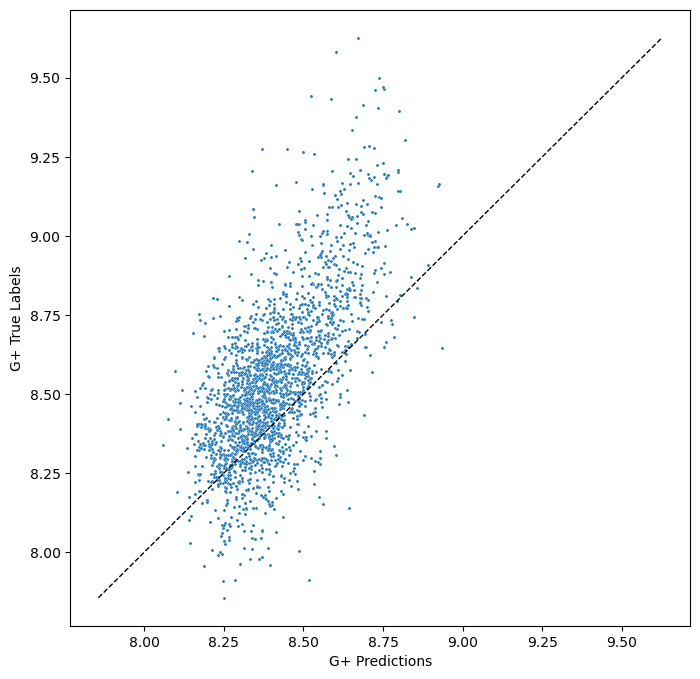

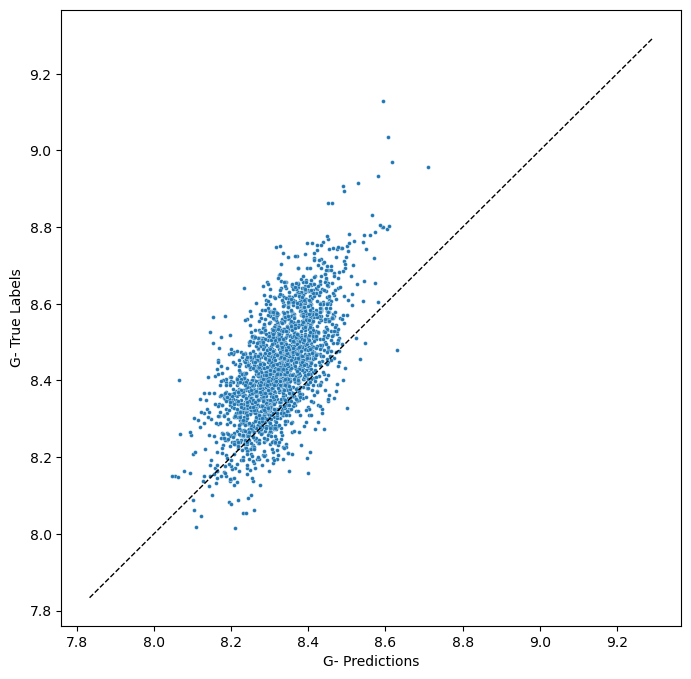

Pearson correlation for Predictions_GFP+: 0.6564597846090628
Pearson correlation for Predictions_GFP-: 0.4024922023741781


In [13]:
# Plot for Predictions_GFP+
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_predictions_d['Predictions_GFP+'], y=df_predictions['True_GFP+'], s=5)

# Add diagonal line
min_val = min(df_predictions_d['Predictions_GFP+'].min(), df_predictions['True_GFP+'].min())
max_val = max(df_predictions_d['Predictions_GFP+'].max(), df_predictions['True_GFP+'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('G+ Predictions')
plt.ylabel('G+ True Labels')
#plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for G+')

# Show the plot
plt.show()

# Plot for Predictions_GFP-
plt.figure(figsize=(8, 8))
sns.scatterplot(x=df_predictions_d['Predictions_GFP-'], y=df_predictions['Predictions_GFP-'], s=8)

# Add diagonal line
min_val = min(df_predictions_d['Predictions_GFP-'].min(), df_predictions['True_GFP-'].min())
max_val = max(df_predictions_d['Predictions_GFP-'].max(), df_predictions['True_GFP-'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('G- Predictions')
plt.ylabel('G- True Labels')
#plt.title('Correlation between Predictions of ExplaiNN and DeepSTARR for G-')

# Show the plot
plt.show()

from scipy.stats import pearsonr

# Calculate Pearson correlation for Predictions_GFP+
correlation_gfp_plus, _ = pearsonr(df_predictions_d['Predictions_GFP+'], df_predictions['True_GFP+'])
print(f"Pearson correlation for Predictions_GFP+: {correlation_gfp_plus}")

# Calculate Pearson correlation for Predictions_GFP-
correlation_gfp_minus, _ = pearsonr(df_predictions_d['Predictions_GFP-'], df_predictions['True_GFP-'])
print(f"Pearson correlation for Predictions_GFP-: {correlation_gfp_minus}")


# Train ExplaiNN Predict G+ and G- with Rep1 data

In [3]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_G+G-_Rep1_Metrics.csv')
cnns = list(set(params['num_cnns']))

temp_df = params[params['num_cnns'] == 60]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

num_cnns = 60
target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep1_Pred_60NN'

print(f'cnn: {num_cnns}')
print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

seed = best_seed
batch = best_batch
learning_rate= best_lr

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_rep1_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)

# Process datasets
train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode = 'none')
test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode = 'none')
validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)


input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 2, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader,test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

cnn: 60
lr: 0.001    drop_out: 0.3
batch: 168    seed: 630
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/60, Loss: 69.0956
Epoch 1/200 -- Train Loss: 55.5855 , Validation Loss: 43.3523
------------------------Evaluation------------------------
Label 1: MSE=45.4441, RMSE=6.7412, MAE=6.7338, R^2=-820.4113, Pearson=0.3163, Spearman=0.2843
Label 2: MSE=41.2952, RMSE=6.4261, MAE=6.4185, R^2=-897.6286, Pearson=0.1983, Spearman=0.1907
Overall (Flattened): MSE=43.3696, RMSE=6.5856, MAE=6.5762, R^2=-804.7505, Pearson=0.1587, Spearman=0.1404
----------------------------------------------------------
Epoch 2/200, Step 1/60, Loss: 42.4086
Epoch 2/200 -- Train Loss: 30.6482 , Validation Loss: 19.1209
------------------------Evaluation------------------------
Label 1: MSE=20.4918, RMSE=4.5268, MAE=4.5119, R^2=-369.3936, Pearson=0.2756, Spearman=0.2590
Label 2: MSE=17.7586, RMSE=4.2141, MAE=4.2005, R^2=-385.4456, Pearson=0.1981, Spearman=0.1936
Overall (Flattened): MSE=19.1252, RM

In [4]:
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep1_Pred_60NN/best_pearson*.pth')
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep1_Pred_60NN'

for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    _ = process_and_save_results(train_loader, 'train', input_model, weight_file, target_labels, output_dir, device)
    _  = process_and_save_results(val_loader, 'validation', input_model, weight_file, target_labels, output_dir, device)
    df_predictions = process_and_save_results(test_loader, 'test', input_model, weight_file, target_labels, output_dir, device)



Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep1_Pred_60NN/best_pearson_model_epoch_52.pth
Results for train saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep1_Pred_60NN/train_prediction_results.csv
Results for validation saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep1_Pred_60NN/validation_prediction_results.csv
Results for test saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep1_Pred_60NN/test_prediction_results.csv


# Train ExplaiNN Predict G+ and G- with Rep1 data

In [6]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN/ExplaiNN3_G+G-_Rep2_Metrics.csv')
#cnns = list(set(params['num_cnns']))

temp_df = params[params['num_cnns'] == 75]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

num_cnns = 75
target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep2_Pred_75NN'

print(f'cnn: {num_cnns}')
print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

seed = best_seed
batch = best_batch
learning_rate= best_lr

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_rep2_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)

# Process datasets
train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode = 'none')
test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode = 'none')
validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)


input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 2, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader,test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

cnn: 75
lr: 0.0001    drop_out: 0.3
batch: 168    seed: 630
Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/59, Loss: 71.3422
Epoch 1/200 -- Train Loss: 70.0175 , Validation Loss: 68.9651
------------------------Evaluation------------------------
Label 1: MSE=70.8416, RMSE=8.4167, MAE=8.4107, R^2=-784.1010, Pearson=0.2273, Spearman=0.2192
Label 2: MSE=67.0992, RMSE=8.1914, MAE=8.1859, R^2=-1190.6455, Pearson=0.0445, Spearman=0.0484
Overall (Flattened): MSE=68.9704, RMSE=8.3048, MAE=8.2983, R^2=-929.6788, Pearson=0.0924, Spearman=0.0944
----------------------------------------------------------
Epoch 2/200, Step 1/59, Loss: 67.8587
Epoch 2/200 -- Train Loss: 66.2504 , Validation Loss: 65.5834
------------------------Evaluation------------------------
Label 1: MSE=67.3261, RMSE=8.2052, MAE=8.1994, R^2=-745.1408, Pearson=0.3303, Spearman=0.3132
Label 2: MSE=63.8571, RMSE=7.9911, MAE=7.9855, R^2=-1133.0688, Pearson=0.0667, Spearman=0.0695
Overall (Flattened): MSE=65.5916,

In [7]:
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep2_Pred_75NN/best_pearson*.pth')
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep2_Pred_75NN'

for weight_file in file_list:
    print(f"Evaluating model with weights from: {weight_file}")
    _ = process_and_save_results(train_loader, 'train', input_model, weight_file, target_labels, output_dir, device)
    _  = process_and_save_results(val_loader, 'validation', input_model, weight_file, target_labels, output_dir, device)
    df_predictions = process_and_save_results(test_loader, 'test', input_model, weight_file, target_labels, output_dir, device)



Evaluating model with weights from: /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep2_Pred_75NN/best_pearson_model_epoch_108.pth
Results for train saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep2_Pred_75NN/train_prediction_results.csv
Results for validation saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep2_Pred_75NN/validation_prediction_results.csv
Results for test saved to /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Rep2_Pred_75NN/test_prediction_results.csv
